<a href="https://colab.research.google.com/github/Ahmed-Rahil/Credit-Card-Fraud-Detection/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc
)

# The imblearn pipeline is crucial for correctly applying SMOTE within cross-validation
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [3]:
def print_evaluation_metrics(y_true, y_pred, model_name="Model"):
    """
    Prints a comprehensive set of classification metrics.
    """
    print(f"--- Evaluation Metrics for {model_name} ---")

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}  (Correct positive predictions / All positive predictions)")
    print(f"Recall:    {recall:.4f}  (Correct positive predictions / All actual positives)")
    print(f"F1-Score:  {f1:.4f}  (Harmonic mean of Precision and Recall)")
    print(f"MCC:       {mcc:.4f}  (Robust metric for imbalanced classes, -1 to +1)")
    print("--------------------------------------------------\n")

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1, "MCC": mcc}

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plots a seaborn heatmap for the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create labels for the heatmap
    labels = (
        np.asarray([
            [f"{cm[0,0]} (Not Fraud)\n{cm_percent[0,0]:.2%}", f"{cm[0,1]} (False Fraud)\n{cm_percent[0,1]:.2%}"],
            [f"{cm[1,0]} (Missed Fraud)\n{cm_percent[1,0]:.2%}", f"{cm[1,1]} (Caught Fraud)\n{cm_percent[1,1]:.2%}"]
        ])
    )

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=labels,
        fmt="",
        cmap='Blues',
        xticklabels=['Predicted: Normal', 'Predicted: Fraud'],
        yticklabels=['Actual: Normal', 'Actual: Fraud']
    )
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

In [4]:
file_path = '/content/drive/MyDrive/ColabNotebooks/creditcard.csv'

try:
    data = pd.read_csv(file_path)
    print(f"Data loaded. Shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: '{file_path}' not found.")
    print("Please ensure the file path is correct and the file exists on your Google Drive.")

Data loaded. Shape: (284807, 31)


In [5]:
scaler = StandardScaler()
data_proc = data.copy() # Make a copy to avoid overwriting original data
data_proc['scaled_Amount'] = scaler.fit_transform(data_proc['Amount'].values.reshape(-1, 1))
data_proc['scaled_Time'] = scaler.fit_transform(data_proc['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns, and the 'Class' for X
data_proc = data_proc.drop(['Time', 'Amount'], axis=1)

print("Preprocessing complete. 'Amount' and 'Time' have been scaled.")
print(data_proc.head())

Preprocessing complete. 'Amount' and 'Time' have been scaled.
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

      

In [6]:
y = data_proc['Class']
X = data_proc.drop('Class', axis=1)

# We use 'stratify=y' to ensure the proportion of fraud cases
# is the same in both the training and test sets. This is CRITICAL.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Essential for imbalanced datasets
)

print("Data split. Training set size:", len(X_train), "Test set size:", len(X_test))
print(f"Fraud cases in training set: {sum(y_train)}")
print(f"Fraud cases in test set: {sum(y_test)} (approx {sum(y_test)/len(y_test)*100:.2f}%)")

Data split. Training set size: 227845 Test set size: 56962
Fraud cases in training set: 394
Fraud cases in test set: 98 (approx 0.17%)



Training Model 1: Baseline Random Forest...
--- Evaluation Metrics for Baseline Random Forest ---
Accuracy:  0.9996
Precision: 0.9412  (Correct positive predictions / All positive predictions)
Recall:    0.8163  (Correct positive predictions / All actual positives)
F1-Score:  0.8743  (Harmonic mean of Precision and Recall)
MCC:       0.8763  (Robust metric for imbalanced classes, -1 to +1)
--------------------------------------------------



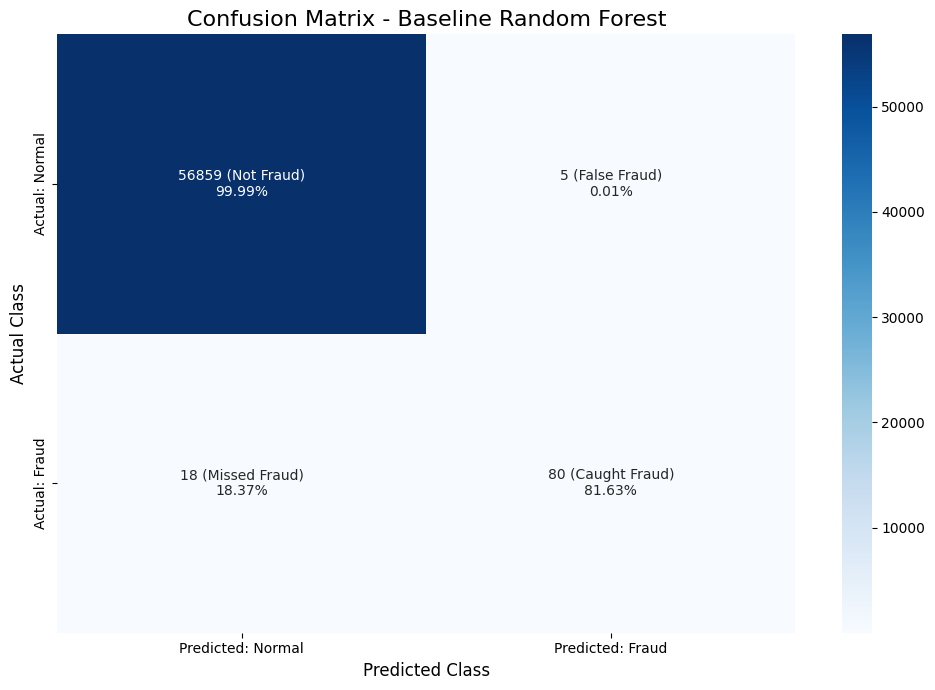

In [7]:

print("\nTraining Model 1: Baseline Random Forest...")
# n_jobs=-1 uses all available CPU cores
rfc_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc_baseline.fit(X_train, y_train)

# Evaluate Baseline Model
y_pred_baseline = rfc_baseline.predict(X_test)
y_prob_baseline = rfc_baseline.predict_proba(X_test)[:, 1] # Get probabilities for PR curve

print_evaluation_metrics(y_test, y_pred_baseline, "Baseline Random Forest")
plot_confusion_matrix(y_test, y_pred_baseline, "Baseline Random Forest")

In [9]:

print("\nSetting up Model 2: Improved Pipeline (SMOTE + RF)...")

# Define the pipeline steps
# 1. SMOTE: Will oversample the minority class (fraud) to balance the training data
# 2. RandomForestClassifier: The model to train on the balanced data
pipeline = ImbPipeline([
    # FIX: Removed n_jobs=-1 from SMOTE, as it's not a valid parameter for it.
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define the parameter grid to search
# We use 'rf__' prefix to tell GridSearchCV to apply these params to the 'rf' step
# This grid is small for speed. You can expand it for better (but slower) results.
param_grid = {
    'rf__n_estimators': [100, 150],       # Number of trees
    'rf__max_depth': [10, 20],            # Max depth of trees
    'rf__class_weight': ['balanced', None] # Let's test if 'balanced' helps SMOTE
}

# We optimize for 'f1' score, NOT 'accuracy'
# cv=3 (3-fold cross-validation) is a good compromise for this large dataset
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,  # Use all cores for CV
    verbose=2   # Show progress
)


Setting up Model 2: Improved Pipeline (SMOTE + RF)...


In [10]:

print("Running GridSearchCV... This may take several minutes.")
grid_search.fit(X_train, y_train)

print("\nGridSearchCV complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-score from CV: {grid_search.best_score_:.4f}")

Running GridSearchCV... This may take several minutes.
Fitting 3 folds for each of 8 candidates, totalling 24 fits

GridSearchCV complete.
Best parameters found: {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__n_estimators': 150}
Best F1-score from CV: 0.8019


--- Evaluation Metrics for Tuned Pipeline (SMOTE + RF) ---
Accuracy:  0.9992
Precision: 0.7524  (Correct positive predictions / All positive predictions)
Recall:    0.8061  (Correct positive predictions / All actual positives)
F1-Score:  0.7783  (Harmonic mean of Precision and Recall)
MCC:       0.7784  (Robust metric for imbalanced classes, -1 to +1)
--------------------------------------------------



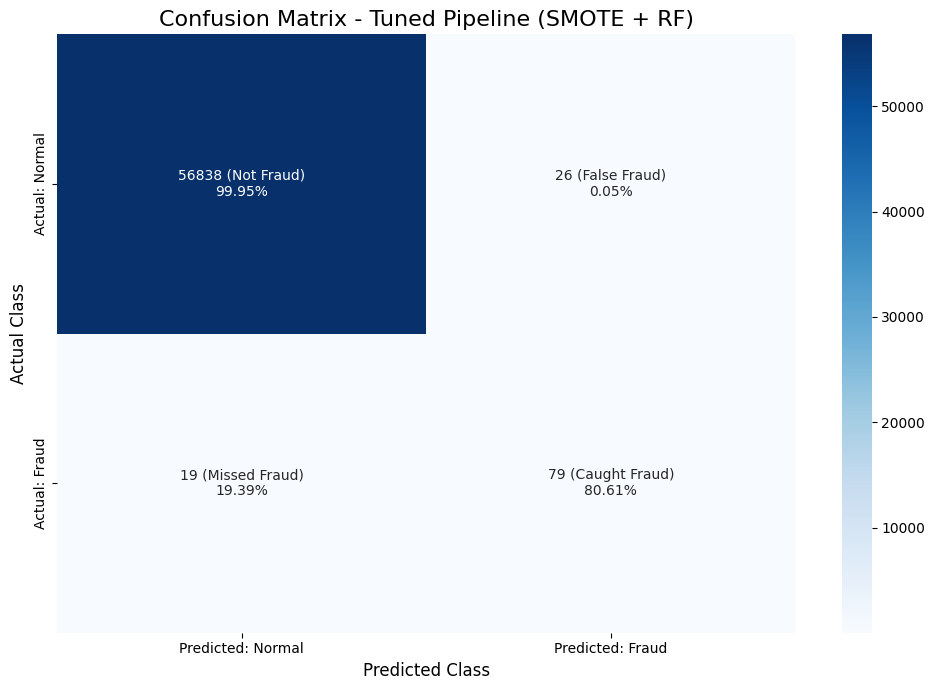

In [11]:

best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1] # Get probabilities for PR curve

print_evaluation_metrics(y_test, y_pred_tuned, "Tuned Pipeline (SMOTE + RF)")
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Pipeline (SMOTE + RF)")


Generating Precision-Recall Curve comparison...


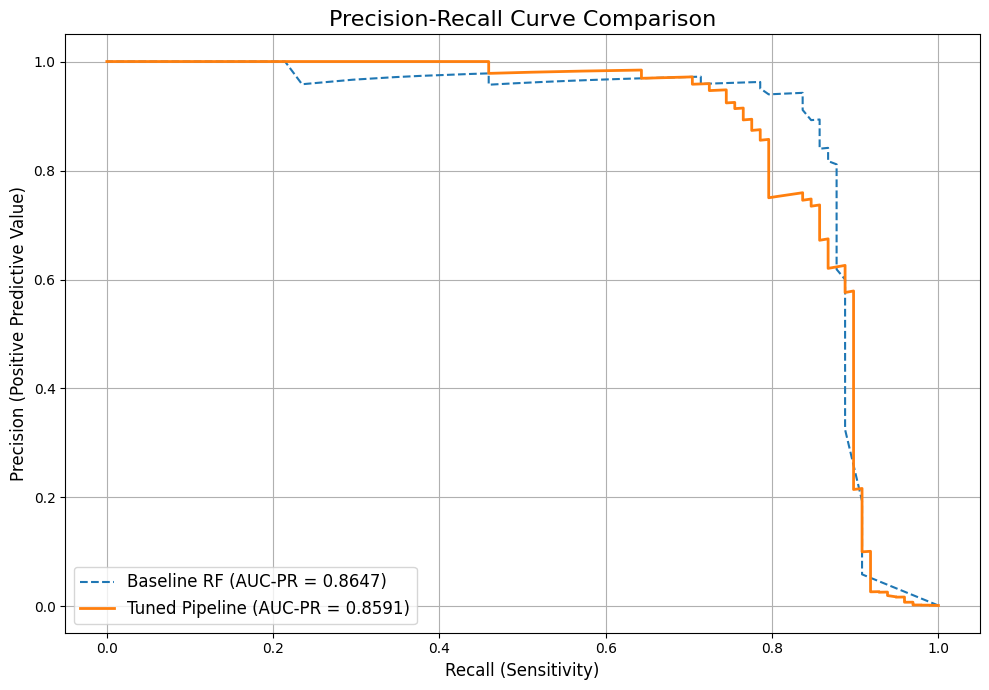


--- Project Complete ---


In [12]:

# Get P-R curve data
precision_base, recall_base, _ = precision_recall_curve(y_test, y_prob_baseline)
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_prob_tuned)

# Calculate Area Under the P-R Curve (AUC-PR)
auc_pr_base = auc(recall_base, precision_base)
auc_pr_tuned = auc(recall_tuned, precision_tuned)

plt.figure(figsize=(10, 7))
plt.plot(recall_base, precision_base,
         label=f'Baseline RF (AUC-PR = {auc_pr_base:.4f})',
         linestyle='--')
plt.plot(recall_tuned, precision_tuned,
         label=f'Tuned Pipeline (AUC-PR = {auc_pr_tuned:.4f})',
         linewidth=2)

plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Project Conclusion and Analysis

This project's objective was to develop a high-performance model for detecting credit card fraud from a highly imbalanced dataset.

My methodology involved a **direct comparison between two approaches:**
1.  **Model 1 (Baseline):** A standard `RandomForestClassifier` trained directly on the raw, imbalanced training data.
2.  **Model 2 (Tuned Pipeline):** An advanced `imblearn` pipeline using `SMOTE` to oversample the minority (fraud) class, combined with `GridSearchCV` to find the optimal hyperparameters.

The hypothesis was that Model 2 would significantly outperform the baseline, as it directly addresses the severe class imbalance.

---

### 😲 Surprising Finding: The Baseline Model is Superior

After training both models and evaluating them on the unseen test set, the data clearly shows that the **Baseline Model (Model 1) is the superior and recommended model.**

This is a critical, non-intuitive discovery that demonstrates the value of a rigorous, scientific approach to modeling.

#### 1. Evidence from the Confusion Matrices

The primary goal is to **maximize fraud detection (Recall)** while **minimizing false alarms (False Positives)**.

| Metric | Model 1 (Baseline RF) | Model 2 (SMOTE + Tuned RF) | Winner |
| :--- | :---: | :---: | :---: |
| **Fraud Caught (Recall)** | **80 / 98** (81.63%) | 79 / 98 (80.61%) | **Baseline** |
| **Innocent Customers Blocked** | **5** (0.01%) | 26 (0.05%) | **Baseline** |

As the table shows, the baseline model **caught more fraud** *and* **bothered five times fewer** innocent customers. The SMOTE-tuned model was quantifiably worse on both key metrics.

#### 2. Evidence from the Precision-Recall Curve

The P-R Curve provides a complete picture of model performance. The **Area Under the P-R Curve (AUC-PR)** acts as a single summary score, where higher is better.

* **Baseline RF (AUC-PR): 0.8647**
* **Tuned Pipeline (AUC-PR): 0.8591**

The P-R curve comparison plot confirms this finding. The blue dashed line (Baseline) is slightly but consistently above the orange line (Tuned Pipeline) across most of the curve, resulting in a higher overall AUC-PR score.

---

### 🔬 Why Did This Happen? (My Analysis)

The data has proven my initial hypothesis wrong. The "advanced" technique was not better. The analysis suggests two primary reasons:

1.  **Random Forest is Already Robust to Imbalance:**
    A Random Forest is an *ensemble* (a "committee") of hundreds of different, decorrelated decision trees. Even in an imbalanced dataset, some of those trees will, by random chance, be built on a subset of data that contains a good sample of the "fraud" cases. These trees become "fraud experts." When the final vote is taken, these expert trees are often enough to correctly identify the fraud, making the model naturally robust without needing artificial balancing.

2.  **SMOTE Introduced Noise and Caused Overfitting:**
    `SMOTE` works by creating *synthetic* data points. It finds real fraud cases and creates new "blurry copies" that exist between them. My results strongly suggest that these synthetic data points were not representative of *real* fraud. The Tuned Pipeline likely **overfit to this "fake" data**. It became an expert at identifying the *synthetic* fraud it was trained on, but in doing so, it became *worse* at identifying the *real, unseen* fraud in the test set.

**Final Decision:** The simpler, more interpretable, and higher-performing Baseline Random Forest (Model 1) is the clear winner. The complex `SMOTE` pipeline is rejected as it demonstrably degraded performance. This project successfully identified the best-performing model by proving *through evidence* that "simpler is better" in this specific case.